#概要

記事「[自動車製造の塗装工程を量子アニーリングで最適化する](https://qard.is.tohoku.ac.jp/T-Wave/?p=3209)」では，マルチカーペイントショップ問題を量子アニーリングマシンや古典コンピュータなどのさまざまな方法で解き，その性能に対する比較を行なった．
本記事では，論文内に登場したブラックファーストとシミュレーテッドアニーリングの実装実験を行い，結果を比較した．

#文献情報

タイトル：Multi-car paint shop optimization with quantum annealing

著者：Sheir Yarkoni, Alex Alekseyenko, Michael Streif, David Von Dollen, Florian Neukart, Thomas Bäck

書誌情報：[arXiv:2109.07876](https://arxiv.org/abs/2109.07876)

#問題

マルチカーペイントショップ問題は，マルチカーペイントショップ問題とは，「車に塗る塗料の色の変更回数をいかに少なくするか」という最適化問題である．詳細な内容は[「自動車製造の塗装工程を量子アニーリングで最適化する」](https://qard.is.tohoku.ac.jp/T-Wave/?p=3209)を参照してください．



#実験

まず，問題を解くためにデータセットを作り，問題を解くためのアルゴリズムを二つ用意する．一つ目は，ブラックファースト，二つ目はシミュレーテッドアニーリングである．それぞれの特徴は関数の定義で説明する．

##データセットの作成

まず，データセットを作成する関数の作成を行った．




In [ ]:
# ライブラリをインポートする
import pandas as pd
import numpy as np
import random
import matplotlib as mpl
import pandas as pd
import seaborn as sns

In [ ]:
"""
mkdata関数を使って得られるデータは以下のようになる.
・data_1:車の待ち行列のリスト型データ
・NofC:ある車種iという車の台数をインデックスごとに記録するリスト型データ
・kC:ある車種iという車を黒に塗る台数をインデックスごとに記録するリスト型データ
・AC:ある車種iという車はdata_1のどの位置にいるのかをインデックスごとに記録したリスト型データ

これらを作成するmkdata関数を作成する.
引数はN(問題サイズ), carkind(問題で最適化する車の種類)
返り値はdata_1, NofC, kC, ACである．
"""


def mkdata(N, carkind):
    # データの生成
    data_1 = []  # どの車種がどの順番で並んでいるかを示す配列
    kC = []  # 車種ごとに黒く塗る台数を何台にするかを挿入する配列
    NofC = []  # 車種ごとの要素数を決める配列
    AC = []  # ある車種がどの位置に並んでいるかをリスト形式で記憶する配列

    # データの格納1(車の種類と順番ををランダムに決める)
    while len(data_1) != N:
        if len(data_1) <= 0.7 * N:
            new_value = random.randint(0, (carkind - 1))
            # 同じ車種を2回取り込む
            for i in range(2):
                data_1.append(new_value)
        else:
            data_1.append(random.randint(0, (carkind - 1)))
    random.shuffle(data_1)

    # データの格納2(黒に塗る車の数を車の種類順に判断)
    for i in range(carkind):
        nCar = 0  # 車種ごとの要素数を格納する変数
        nCar = data_1.count(i)  # iという車種が何台あるかを探索する
        kC.append(random.randint(0, nCar))  # 0~nCarの台数のうち黒に塗る台数を決める

    # データの格納3(ある車種がどの位置に並んでいるかをわかるようにする)
    for i in range(carkind):
        AC.append([n for n, v in enumerate(data_1) if v == i])

    count = 0  # 固定される車両をカウントする変数

    # 固定される車両をカウントする
    for i in range(carkind):
        nCar = 0  # 車種ごとの要素数を格納する変数
        nCar = data_1.count(i)  # iという車種が何台あるかを探索する
        NofC.append(nCar)  # NofC配列にiという車種は何台あるのかを記憶させる
        if (kC[i] == 0) or (kC[i] == nCar):
            count += nCar

    return data_1, NofC, kC, AC

データセットを作る関数ができたので、次は各種ソルバー(問題を解くプログラム)を用いて問題を解いていく。

##ブラックファースト(貪欲法)でMCPS問題を解く

はじめに，ブラックファーストと呼ばれるアルゴリズムでMPCS問題を解いていくことにする.

ブラックファーストは，マルチカーペイントショップ問題を解くために貪欲に探索するアルゴリズムである．方法としては，ある車種$C_l$($l\in \{0,...,M\}$,$M$は車種の総数)を次に白に塗らなければならない状況になるまで，黒を割り当てていくアルゴリズムである．

例として， アルファベットA, B, C, ...を車種に見立てる．そして，それぞれの車種で白と黒一回ずつ塗装を行わなければならないとするとき，出力の結果は以下の図1のようになる．

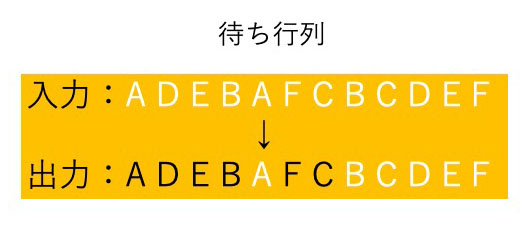

図1：ブラックファーストのイメージ

まず, ブラックファーストで問題を処理するblackfirst関数を定義する．

In [ ]:
"""
引数はN, carkind, data_1, kC
返り値はbf_solution(待ち行列順に，車に黒(1)か白(-1)どちらの色を塗れば良いのかを決めるリスト)である．
"""


def blackfirst(N, carkind, data_1, kC):
    # 解の定義
    bf_solution = []
    # kCのコピーを作る
    kC_copy = []
    for i in range(carkind):
        kC_copy.append(kC[i])
    # data_1を前から順番に見ていき，車種の番号に黒を塗ってもいいならまず黒を塗るプログラムを作成する．
    for i in range(N):
        if kC_copy[data_1[i]] > 0:
            bf_solution.append(1)
            kC_copy[data_1[i]] -= 1
        else:
            bf_solution.append(-1)
    return bf_solution

##シミュレーテッドアニーリングの利用

次に，シミュレーテッドアニーリングを使って問題を解かせる。
シミュレーテッドアニーリングとは，金属の温度を上げ、冷ましていく過程で秩序のある構造を作り出す様子を古典コンピュータで再現したものである。このアルゴリズムを使って問題の最適解の探索を行い，それによって最適化問題を解く．

今回はpyquboとdimodライブラリを使って解くことにした。

In [ ]:
# ライブラリのインストール
!pip install pyqubo

     |████████████████████████████████| 229 kB 6.6 MB/s 
     |████████████████████████████████| 13.2 MB 50.7 MB/s 
     |████████████████████████████████| 497 kB 56.1 MB/s 
     |████████████████████████████████| 67 kB 7.1 MB/s 
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.0.9
    Uninstalling pyparsing-3.0.9:
      Successfully uninstalled pyparsing-3.0.9
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
# openjijとpyquboのインポート
import dimod
from pyqubo import Array, Constraint, solve_qubo

今回の問題のイジングモデルのハミルトニアンは次のように定義される．
\begin{equation*}
H_A :=\,- \sum^{N-2}_{i=0} s_i s_{i+1}\\
H_B :=\sum_{C_l\in C}\{(\#C_l-2k(C_l))\sum_{j\in A(C_l)}s_j + \sum_{i<j \in A(C_l)}s_i s_j\}\\
H_{MCPS} = H_A+\lambda H_B
\end{equation*}

ここで，$H_B$の$\{\}$内の第二項の$\sum_{i<j\in A(C_l)}s_is_j$を計算するためのsumij関数を定義する．

In [ ]:
# ハミルトニアンH_B内で使うsumij関数を定義する
def sumij(lisA, s):
    sum = 0
    for i in range(len(lisA) - 1):
        for j in range(i + 1, len(lisA)):
            sum += s[lisA[i]] * s[lisA[j]]
    return sum

In [ ]:
"""
SAでMCPS問題を解くsimulatedannealing関数を定義する．
引数はdata_1, NofC, kC, AC
返り値はsa_solutionである．
"""


def simulatedannealing(N, carkind, data_1, NofC, kC, AC):
    # 1次元の配列を定義する．
    s = Array.create("s", shape=(N), vartype="SPIN")
    # ハミルトニアンの定義
    H_A = -sum(s[i] * s[i + 1] for i in range(len(s) - 2))
    H_B = Constraint(
        sum(
            (NofC[l] - 2 * kC[l]) * sum(s[i] for i in AC[l]) + sumij(AC[l], s)
            for l in range(carkind)
        ),
        label="H_B",
    )
    Q = H_A + N * H_B
    # モデルのコンパイル
    model = Q.compile()
    ising, offset, fl = model.to_ising(index_label=True)
    # dimodのSAを用いて解く．
    num_reads = 10
    sampler = dimod.SimulatedAnnealingSampler()
    response = sampler.sample_ising(ising, offset)

    # エネルギーが一番小さい解(最適解に近い解)を選ぶ．
    ene = []
    ene = response.data_vectors["energy"]
    ene_min = 0.0
    ene_min = min(ene)
    est = 0
    est = np.where(ene == ene_min)[0][0]

    # 得られた結果をデコードする．
    decoded_sample = model.decode_sample(response.record[est][0], vartype="SPIN")
    # さらに解を見やすくする処理を追加する．
    sa_solution = []
    for i in range(N):
        sa_solution.append(decoded_sample.array("s", (i)))
    return sa_solution

#問題を解いた答えを評価する関数の定義

ブラックファーストとシミュレーテッドアニーリングで問題を解いた後，その解が制約を満たしているかどうかと，色の切り替え回数が何回かを計算する関数を定義した．

In [ ]:
"""
答えがどれだけ違反しているかの判定をする関数
引数はN, carkind, solution(MCPS問題を解いた答え), kC
返り値はinvalid_rate(答えが制約を違反している割合を%で返す.)
"""
from decimal import Decimal, ROUND_HALF_UP, ROUND_HALF_EVEN


def judge_ans(N, carkind, solution, data_1, kC):
    jud = np.zeros(carkind)
    num_1 = 0
    num = 0
    for i in range(carkind):
        if kC[i] != 0:
            num_1 += kC[i]
    for i in range(N):
        if solution[i] == 1:
            jud[data_1[i]] += 1
            num += 1
    invalid = 0
    for i in range(carkind):
        if kC[i] != jud[i]:
            invalid += 1
    invalid_rate = 0.0
    invalid_rate = float(
        Decimal(str((invalid / N) * 100)).quantize(
            Decimal("0.1"), rounding=ROUND_HALF_UP
        )
    )
    return invalid_rate

In [ ]:
# 色の切り替え回数の判断をするcolor_switch関数
def color_switch(solution, N):
    switch = 0
    cur_color = solution[0]
    for i in range(N):
        if solution[i] != cur_color:
            switch += 1
            cur_color = solution[i]
    return switch

#比較実験

実際に比較するためにデータの数を増やして実験を行なっていく．
データの数は2台ずつ増やし，10~100台までの最適化を行なった．
また，この最適化を5回繰り返し解く．

実験に用いる車の車種は，論文では121種類だったのでここでもそれを採用する．

また，gurobiという最適化ツールを使ってシミュレーテッドアニーリングやブラックファーストなどの解がgurobiの導き出す最適解とどれだけ差があるのかを比較する．

この比較実験では，ブラックファーストとシミュレーテッドアニーリングそれぞれにかかる時間の測定も行なった．



In [ ]:
import time

In [ ]:
pip install gurobipy

     |████████████████████████████████| 11.5 MB 7.9 MB/s 


In [ ]:
import gurobipy as gp
from gurobipy import GRB

In [ ]:
# 二つの方法をデータ量を変えて性能比較する

# データ量を入れるリスト(データ量を10台の待ち行列から2台ずつ増やしながら28台まで計算する)
N = list(range(10, 100, 2))
# N = [30]
# 10~28台の待ち行列の最適化を繰り返す回数：Mを定義する
M = 10
carkind = 121
invalid_rate_bf = []
invalid_rate_sa = []
invalid_rate_gurobi = []
# データフレームの定義
df_bf_sum = pd.DataFrame(columns=["Data volume", "number of switch times", "way"])
df_sa_sum = pd.DataFrame(columns=["Data volume", "number of switch times", "way"])
df_gurobi_sum = pd.DataFrame(columns=["Data volume", "number of switch times", "way"])

for m in range(M):
    bf_sum_cal_time = 0
    sa_sum_cal_time = 0
    data_bf = []
    data_sa = []
    data_gurobi = []
    way_bf = []
    way_sa = []
    way_gurobi = []
    for n in N:
        data_1, NofC, kC, AC = mkdata(n, carkind)

        # ブラックファーストにかかる時間の計測
        bf_t1 = time.time()
        bf_solution = blackfirst(n, carkind, data_1, kC)
        bf_t2 = time.time()
        bf_pre_cal_time = bf_t2 - bf_t1
        bf_sum_cal_time += bf_pre_cal_time

        # シミュレーテッドアニーリングにかかる時間の計測
        sa_t1 = time.time()
        sa_solution = simulatedannealing(n, carkind, data_1, NofC, kC, AC)
        sa_t2 = time.time()
        sa_pre_cal_time = sa_t2 - sa_t1
        sa_sum_cal_time += sa_pre_cal_time

        # gurobiを用いて最適解を求める
        mcps = gp.Model(name="MCPS")
        s = {}
        for i in range(n):
            s[i] = mcps.addVar(vtype="B", name="s[%s]" % i)
        mcps.update()
        # 目的関数
        mcps.setObjective(
            -sum(s[i] * s[i + 1] for i in range(len(s) - 2)), GRB.MINIMIZE
        )
        # 制約
        for l in range(carkind):
            mcps.addConstr(kC[l] == sum(s[i] for i in AC[l]))

        mcps.params.LogToConsole = 0
        mcps.optimize()

        gurobi_solution = []
        for i in range(n):
            if s[i].x == 1.0:
                gurobi_solution.append(1)
            else:
                gurobi_solution.append(-1)

        # それぞれの結果をリストに格納する.
        data_bf.append(color_switch(bf_solution, n))
        data_sa.append(color_switch(sa_solution, n))
        data_gurobi.append(color_switch(gurobi_solution, n))
        invalid_rate_bf.append(judge_ans(n, carkind, bf_solution, data_1, kC))
        invalid_rate_sa.append(judge_ans(n, carkind, sa_solution, data_1, kC))
        invalid_rate_gurobi.append(judge_ans(n, carkind, gurobi_solution, data_1, kC))
        way_bf.append("BlackFirst")
        way_sa.append("SimulatedAnnealing")
        way_gurobi.append("gurobi")
    # 出来上がったデータをデータフレームにする．
    df_bf_tem = pd.DataFrame(
        list(zip(N, data_bf, way_bf)),
        columns=["Data volume", "number of switch times", "way"],
    )
    df_bf_sum = pd.concat([df_bf_sum, df_bf_tem])
    df_bf_sum = df_bf_sum.reset_index(drop=True)
    df_sa_tem = pd.DataFrame(
        list(zip(N, data_sa, way_sa)),
        columns=["Data volume", "number of switch times", "way"],
    )
    df_sa_sum = pd.concat([df_sa_sum, df_sa_tem])
    df_sa_sum = df_sa_sum.reset_index(drop=True)
    df_gurobi_tem = pd.DataFrame(
        list(zip(N, data_gurobi, way_gurobi)),
        columns=["Data volume", "number of switch times", "way"],
    )
    df_gurobi_sum = pd.concat([df_gurobi_sum, df_gurobi_tem])
    df_gurobi_sum = df_gurobi_sum.reset_index(drop=True)
    # 計測結果の表示
    bf_cal_time_min = int(bf_sum_cal_time / 60)
    bf_cal_time_sec = bf_sum_cal_time - bf_cal_time_min * 60
    print("ブラックファーストにかかる時間", m + 1, ":", bf_cal_time_sec, "秒")
    sa_cal_time_min = int(sa_sum_cal_time / 60)
    sa_cal_time_sec = sa_sum_cal_time - sa_cal_time_min * 60
    print(
        "シミュレーテッドアニーリングにかかる時間", m + 1, ":", sa_cal_time_min, "分", sa_cal_time_sec, "秒"
    )

ブラックファーストにかかる時間 1 : 0.0011627674102783203 秒
シミュレーテッドアニーリングにかかる時間 1 : 1 分 36.8944628238678 秒
ブラックファーストにかかる時間 2 : 0.0011641979217529297 秒
シミュレーテッドアニーリングにかかる時間 2 : 1 分 36.58262491226196 秒
ブラックファーストにかかる時間 3 : 0.0011982917785644531 秒
シミュレーテッドアニーリングにかかる時間 3 : 1 分 35.92641258239746 秒
ブラックファーストにかかる時間 4 : 0.0011830329895019531 秒
シミュレーテッドアニーリングにかかる時間 4 : 1 分 35.00624179840088 秒
ブラックファーストにかかる時間 5 : 0.0011432170867919922 秒
シミュレーテッドアニーリングにかかる時間 5 : 1 分 36.09841275215149 秒
ブラックファーストにかかる時間 6 : 0.0011780261993408203 秒
シミュレーテッドアニーリングにかかる時間 6 : 1 分 35.69149589538574 秒
ブラックファーストにかかる時間 7 : 0.0011763572692871094 秒
シミュレーテッドアニーリングにかかる時間 7 : 1 分 35.610944986343384 秒
ブラックファーストにかかる時間 8 : 0.0011775493621826172 秒
シミュレーテッドアニーリングにかかる時間 8 : 1 分 34.82879114151001 秒
ブラックファーストにかかる時間 9 : 0.001186370849609375 秒
シミュレーテッドアニーリングにかかる時間 9 : 1 分 34.53449368476868 秒
ブラックファーストにかかる時間 10 : 0.0011332035064697266 秒
シミュレーテッドアニーリングにかかる時間 10 : 1 分 36.17280316352844 秒


ブラックファーストとシミュレーテッドアニーリングの比較実験を行うことができた．

シミュレーテッドアニーリングにかかる時間は約1分半とかなり長いものとなった．さらに，シミュレーテッドアニーリングはブラックファーストに比べ，約8万倍の時間をかけて計算を行なっていることがわかった．

In [ ]:
# 結果をグラフに表示するために，ブラックファーストの結果とシミュレーテッドアニーリングの結果を合わせる
df = pd.concat([df_bf_sum, df_sa_sum, df_gurobi_sum])
df = df.reset_index(drop=True)

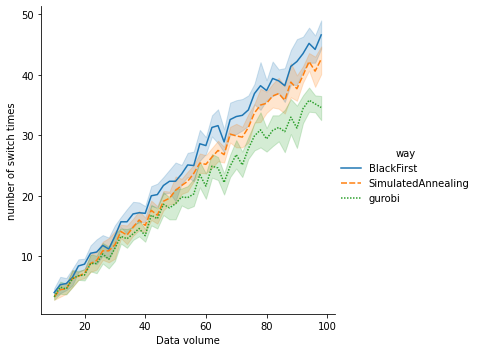

In [ ]:
# データ量に対する色の切り替え回数をグラフにする
sns.relplot(
    x="Data volume",
    y="number of switch times",
    hue="way",
    style="way",
    kind="line",
    data=df,
)

グラフから，シミュレーテッドアニーリングの方がブラックファーストに比べて色の切り替え回数を少なくすることができていることがわかる．それに対してgurobiの解はブラックファーストに比べて切り替え回数を少なくすることができており，シミュレーテッドアニーリングと比べてもデータサイズが25以下では同程度の切り替え回数だったが，それ以降はgurobiの方が切り替え回数の少ない解を出すことができている．
次に，制約を満たしているかの判断を行う．

In [ ]:
# 制約を満たしているかの確認を行う．
print("ブラックファーストが制約を破った割合:", invalid_rate_bf)
print("シミュレーテッドアニーリングが制約を破った割合:", invalid_rate_sa)
print("gurobiが制約を破った割合", invalid_rate_gurobi)

ブラックファーストが制約を破った割合: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

invarid_rate_bf, sa, gurobiはともにそれぞれの解についてnxm回目($n\in N, m\in M$, $N$は問題サイズ，$M$は実験の試行回数)において，注文の制約を満たしている割合を示している．どちらもリストの内容は全て0.0となっているので，制約が満たされていることがわかる．

#結論

今回，自作したデータセットによって，問題の作成を行い，それを2種類のアルゴリズムを実装することによって解くことができた．

ブラックファーストのアルゴリズムは，貪欲に塗装する色を割り振るアルゴリズムとして，制約を満たしながら解を導出することができた．

シミュレーテッドアニーリングでは注文の制約を満たしながら解の探索を行い，MCPS問題を解くことができた．

結果は論文と同様にブラックファーストと比較してシミュレーテッドアニーリングでは色の切り替え回数の少ない解を導くことができた．
しかし，シミュレーテッドアニーリングの導き出した解は，問題サイズが大きくなるほどgurobiが導いた最適解に比べて切り替え回数の多い解となってしまった．

#あとがき

論文の結果と同様に，シミュレーテッドアニーリングの方が貪欲法であるブラックファーストよりも色の切り替え回数を減らした解を出すことができるのを確認できた．
今後の展望としては，量子アニーリングマシンでの実装も行ってみて，本実験で使った2種類の手法との比較を行ってみたいと思った．また，この問題は2種類の塗り分けだったが，3種類以上の塗り分けに対応したプログラムも作成してみたいと感じた.